#### iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋 : iris.csv에서 2개 Feature 사용
- 구현 프레임워크 : Pytorch

- [1] 모듈 로딩 및 데이터 준비

In [1]:
# 모듈 로딩
import torch                                        # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn                               # 인공 신경망 관련 모듈
import torch.nn.functional as F                     # 손실, 거리 등 함수 관련 모듈
import torch.optim as optim                         # 최적화 기법 관련 모듈
from torchmetrics.regression import R2Score         # 성능 지표 관련 모듈 - 추가 설치
from torchinfo import summary                       # 모델 정보 관련 모듈 - 추가 설치

import pandas as pd                                 # 데이터 파일 분석 관련 모듈
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# 모델의 가중치 및 절편 값 고정 설정
torch.manual_seed(1)

# 저장 및 실행 위치 설정
Device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE => {Device}')

DEVICE => cpu


In [3]:
# 데이터 로딩 : CSV => DataFrame
DATA_FILE = '../../ML/data/iris.csv'

irisDF = pd.read_csv(DATA_FILE, usecols=[0,1,2,3])
irisDF.head(2)

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


[2] 모델 준비
- 학습 방법 : 지도학습 > 회귀
- 알고리즘 : 선형관계 >> 선형모델 ==> nn.Linear

In [4]:
# 모델 설계
# 입력층의 입력값/피처 => sepal.length, sepal.width, petal.length     3개
# 출력층의 출력값/타겟 => petal.width        1개
# 입력층    : 입력 : 피처3 / 출력 : 입력층에 존재하는 퍼센트론 개수 10 / AF : ReLU
# 은닉층    : 입력 :   10 / 출력 : 은닉층에 존재하는 퍼셉트론 개수 5 / AF : ReLU
# 출력층    : 입력 :   5  / 출력 : 타겟/라벨 개수 1  / AF : None (선형회귀일 경우 출력 시 활성함수 없어도 됨)

model = nn.Sequential(nn.Linear(3,10),
                         nn.ReLU(),
                         nn.Linear(10,5),
                         nn.ReLU(),
                         nn.Linear(5,1))

In [5]:
# 모델 구조 확인
print(model)
summary(model, input_size=(150,3))

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [150, 1]                  --
├─Linear: 1-1                            [150, 10]                 40
├─ReLU: 1-2                              [150, 10]                 --
├─Linear: 1-3                            [150, 5]                  55
├─ReLU: 1-4                              [150, 5]                  --
├─Linear: 1-5                            [150, 1]                  6
Total params: 101
Trainable params: 101
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.02

In [6]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[0.weight] Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119],
        [ 0.2710, -0.5435,  0.3462],
        [-0.1188,  0.2937,  0.0803],
        [-0.0707,  0.1601,  0.0285],
        [ 0.2109, -0.2250, -0.0421],
        [-0.0520,  0.0837, -0.0023],
        [ 0.5047,  0.1797, -0.2150],
        [-0.3487, -0.0968, -0.2490],
        [-0.1850,  0.0276,  0.3442],
        [ 0.3138, -0.5644,  0.3579]], requires_grad=True)

[0.bias] Parameter containing:
tensor([ 0.1613,  0.5476,  0.3811, -0.5260, -0.5489, -0.2785,  0.5070, -0.0962,
         0.2471, -0.2683], requires_grad=True)

[2.weight] Parameter containing:
tensor([[ 0.3103, -0.1338,  0.2371,  0.0037, -0.1666,  0.1625, -0.1679,  0.0930,
         -0.0913, -0.0347],
        [-0.3040, -0.1508,  0.1716, -0.0769,  0.3150,  0.2535, -0.0148, -0.2111,
          0.1926,  0.0981],
        [-0.2044,  0.2054,  0.1920,  0.2805, -0.1773, -0.0521, -0.0061,  0.0462,
         -0.2400, -0.2244],
        [ 0.1720, -0.0742,  0.1545,  0.0180,  0.1038,  0

[3] 최적화 인스턴스 준비

In [7]:
### 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim = optim.Adam(model.parameters(), lr=0.1)

[4] 학습 ==> 개발자가 구현

- [4-1] 데이터셋 Tensor화 진행 : 데이터 준비 시 진행하거나 학습 전 진행

In [8]:
# 피쳐와 타겟 분리
featureDF = irisDF[irisDF.columns[:-1]]
targetDF = irisDF[['petal.width']]

print(featureDF.shape, targetDF.shape)

(150, 3) (150, 1)


In [9]:
# Train & Test
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF, test_size=0.2, random_state=5)

# Train & Valid
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=5)

print(f'[Feature] TRAIN {X_train.shape}, TEST {X_test.shape}, VAL {X_val.shape}')
print(f'[Target]  TRAIN {y_train.shape}, TEST {y_test.shape}, VAL {y_val.shape}')

[Feature] TRAIN (96, 3), TEST (30, 3), VAL (24, 3)
[Target]  TRAIN (96, 1), TEST (30, 1), VAL (24, 1)


- [4-2] 학습 진행
    * 학습 횟수 결정 ==> 에포크 설정
    * 배치 크기 결정
    * 배치 개수 계산

In [10]:
EPOCH = 100                                # 처음부터 끝까지 공부하는 횟수
BATCH_SIZE = 12                            # 1에포크에서 한번에 학습할 분량 크기
BATCH_CNT = X_train.shape[0]//BATCH_SIZE   # 1에포크에서 총 학습 횟수이면서 가중치 업데이트 횟수

print(f'EPOCH : {EPOCH}, BATCH_SIZE : {BATCH_SIZE}, BATCH_CNT : {BATCH_CNT}')

EPOCH : 100, BATCH_SIZE : 12, BATCH_CNT : 8


In [11]:
## 테스트/검증 함수 
# ==> 가중치, 절편 업데이트 X, 최적화 미진행
# ==> 현재 가중치와 절편값으로 테스트 진행
def testing(testDF, targetDF, kind='Val'):
    # Tensor화
    testTS = torch.FloatTensor(testDF.values).to(Device)
    targetTS = torch.FloatTensor(targetDF.values).to(Device)

    with torch.no_grad():   # 가중치, 절편 업데이트 X
        # (1) 학습 진행 - forward
        pre_y = model(testTS)
        print(f'{pre_y.shape}')
        
        # (2) 오차 계산 - 손실 함수
        loss = F.mse_loss(pre_y, targetTS)

        # (3) 성능평가 - R2
        r2 = R2Score()(pre_y, targetTS)

        # (4) 학습 결과 출력 및 저장
        print(f'[{kind}] Loss : {loss}, R2 : {r2}')

    return loss, r2

In [12]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS):
    # [[],[]] <= [train, val]
    loss_history = [[],[]]
    r2_history = [[],[]]
    
    for epoch in range(EPOCH):
        # 배치 손실 저장 변수
        batch_loss, batch_r2 = 0, 0

        # 배치 크기만큼 학습 진행
        for i in range(BATCH_CNT):
            start = i*BATCH_SIZE
            end = start+BATCH_SIZE

            # BS크기만큼만 데이터 추출해서 Tensor화 진행
            BSX_train = torch.FloatTensor(X_train[start:end].values).to(Device)
            BSy_train = torch.FloatTensor(y_train[start:end].values).to(Device)
            print(f'X_train : {BSX_train.shape}, {BSX_train.device}, {BSX_train.dtype}')
            print(f'y_train : {BSy_train.shape}, {BSy_train.device}, {BSy_train.dtype}')

            # (1) 학습 진행 - forward
            pre_y = model(BSX_train)

            # (2) 오차 계산 - 손실 함수
            loss = F.mse_loss(pre_y, BSy_train)
            batch_loss += loss.item()
            batch_r2 += R2Score()(pre_y, BSy_train).item()
            # loss_history[0].append(loss.item())

            # (3) 최적화 -  가중치, 절편, 업데이트 backward
            adam_optim.zero_grad()
            loss.backward()
            adam_optim.step()

        # (4) 검증 - 모델이 제대로 만들어 지는지 검사
        val_loss, val_r2 = testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())
        r2_history[1].append(val_r2.item())

        # 에포크 단위 손실과 성능지표
        loss_history[0].append(batch_loss/BATCH_CNT)
        r2_history[0].append(batch_r2/BATCH_CNT)

        # (5) 학습 결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}]\nTrain Loss : {loss_history[0][-1]}, R2 : {r2_history[0][-1]}')
        print(f'-Validation Loss : {loss_history[1][-1]}, R2 : {r2_history[1][-1]}')

    return loss_history, r2_history

In [13]:
# 모델 학습 진행
loss, r2 = training(X_train, y_train, X_val, y_val)

X_train : torch.Size([12, 3]), cpu, torch.float32
y_train : torch.Size([12, 1]), cpu, torch.float32
X_train : torch.Size([12, 3]), cpu, torch.float32
y_train : torch.Size([12, 1]), cpu, torch.float32
X_train : torch.Size([12, 3]), cpu, torch.float32
y_train : torch.Size([12, 1]), cpu, torch.float32
X_train : torch.Size([12, 3]), cpu, torch.float32
y_train : torch.Size([12, 1]), cpu, torch.float32
X_train : torch.Size([12, 3]), cpu, torch.float32
y_train : torch.Size([12, 1]), cpu, torch.float32
X_train : torch.Size([12, 3]), cpu, torch.float32
y_train : torch.Size([12, 1]), cpu, torch.float32
X_train : torch.Size([12, 3]), cpu, torch.float32
y_train : torch.Size([12, 1]), cpu, torch.float32
X_train : torch.Size([12, 3]), cpu, torch.float32
y_train : torch.Size([12, 1]), cpu, torch.float32
torch.Size([24, 1])
[Val] Loss : 0.4191381633281708, R2 : -0.004299283027648926
[0/100]
Train Loss : 0.9069786705076694, R2 : -0.5297544598579407
-Validation Loss : 0.4191381633281708, R2 : -0.0042992

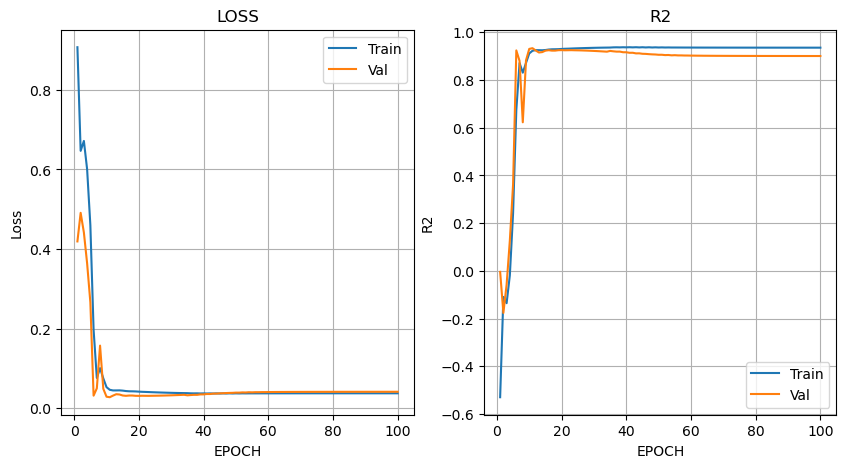

In [14]:
# 학습 후 loss 시각화'
threshold = 100
fg, axes = plt.subplots(1,2, figsize=(10,5))

axes[0].plot(range(1,threshold+1),loss[0][:threshold], label='Train')
axes[0].plot(range(1,threshold+1),loss[1][:threshold], label='Val')
axes[0].grid('--')
axes[0].legend()
axes[0].set_xlabel('EPOCH')
axes[0].set_ylabel('Loss')
axes[0].set_title('LOSS')

axes[1].plot(range(1,threshold+1),r2[0][:threshold], label='Train')
axes[1].plot(range(1,threshold+1),r2[1][:threshold], label='Val')
axes[1].grid('--')
axes[1].legend()
axes[1].set_xlabel('EPOCH')
axes[1].set_ylabel('R2')
axes[1].set_title('R2')
plt.show()